In [453]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
%matplotlib inline

In [454]:
sns.set_style("ticks")
sns.set_palette('muted')

In [455]:
data = pd.read_csv('CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

In [456]:
dfx.shape

(45642, 22)

In [457]:
#Checking Imbalances
Counter(dfx['RESULT'])

Counter({'FUNDED': 36023, 'NOT FUNDED': 9619})

In [458]:
#Checking for Zeros
dfx.isin([0]).any()

Unique_ID            False
MORTGAGE NUMBER      False
PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                   True
LTV                  False
TDS                   True
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE          True
RESULT               False
dtype: bool

In [459]:
#Zero Counts
dfx[dfx[['GDS', 'TDS', 'CREDIT SCORE']] <= 0].count()

Unique_ID               0
MORTGAGE NUMBER         0
PROPERTY VALUE          0
MORTGAGE PAYMENT        0
GDS                   428
LTV                     0
TDS                    80
AMORTIZATION            0
MORTGAGE AMOUNT         0
RATE                    0
MORTGAGE PURPOSE        0
PAYMENT FREQUENCY       0
PROPERTY TYPE           0
TERM                    0
FSA                     0
AGE RANGE               0
GENDER                  0
INCOME                  0
INCOME TYPE             0
NAICS CODE              0
CREDIT SCORE         1176
RESULT                  0
dtype: int64

In [460]:
# Encode Target Variable
def encode_target(df):
    
    df['RESULT'] = df['RESULT'].replace({'NOT FUNDED': 0, 'FUNDED': 1})

    return df

dfx = encode_target(dfx)

In [461]:
dfx.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,...,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,...,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,1
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,...,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,1
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,...,Single Detached,6,M1N,35-39,Female,87000,2,72,709,1
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,...,Single Detached,12,M2M,45-49,Male,300000,8,54,761,1
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,...,Single Detached,12,L7G,50-54,Male,147000,8,62,762,1


In [462]:
# Cleaning Function
def clean_data(df):
    
    # Set Index
    df.set_index('Unique_ID', inplace=True)
    
    # Drop Mortgage Number
    df.drop(['MORTGAGE NUMBER'], axis=1, inplace=True)
    
    # Add Property Value
    df['PROPERTY_VAL_DELTA'] = df['PROPERTY VALUE'] - (df['MORTGAGE AMOUNT'] / (df['LTV'] / 100))
    
    # Update Property Value per Competition
    df['PROPERTY VALUE'] = df['MORTGAGE AMOUNT'] / (df['LTV'] / 100)
    
    # Set Negative GDS Values to Zero, per Competition
    df['GDS'] = np.where(df['GDS'] < 0, 0, df['GDS'])
    
    # Split FSA & Encode Urban or Rural
    df_temp = df['FSA'].str.split('', n=3, expand=True)
    df_temp[2] = df_temp[2].astype(int)
    df_temp['URBAN'] = np.where(df_temp[2] > 0, 1, 0)
    df_temp.drop([0, 2, 3], axis=1, inplace=True)
    
    # Name Territory Column, drop old FSA column
    df_temp.rename(columns={1: 'TERRITORY'}, inplace=True)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['FSA'], axis=1, inplace=True)
    
    return df

df = clean_data(dfx)

In [463]:
# Drop Mortgage Amount & Property Value outliers
z_thresh = 3

def remove_outliers(df):
    
    df['mortgage_amt_z'] = zscore(df['MORTGAGE AMOUNT'])
    df['property_val_z'] = zscore(df['PROPERTY VALUE'])
    
    df = df[(df['property_val_z'] <= z_thresh) & (df['mortgage_amt_z'] <= z_thresh)]
    df = df.drop(['mortgage_amt_z', 'property_val_z'], axis=1)
    
    df = df[(df['RATE'] < 9) & (df['RATE'] > 2.5)]
    
    df = df[(df['LTV'] < 200)]
    
    df = df[(df['TDS'] < 100)]
    
    return df

df = remove_outliers(df)
df['RESULT'].value_counts()

1    35075
0     9219
Name: RESULT, dtype: int64

In [464]:
# Some Credit Scores are Zero
df[df['CREDIT SCORE'] == 0].groupby('RESULT')['CREDIT SCORE'].count()

RESULT
0    301
1    845
Name: CREDIT SCORE, dtype: int64

In [465]:
# Check degree of Imbalance after Cleaning
df['RESULT'].value_counts(normalize=True)

1    0.791868
0    0.208132
Name: RESULT, dtype: float64

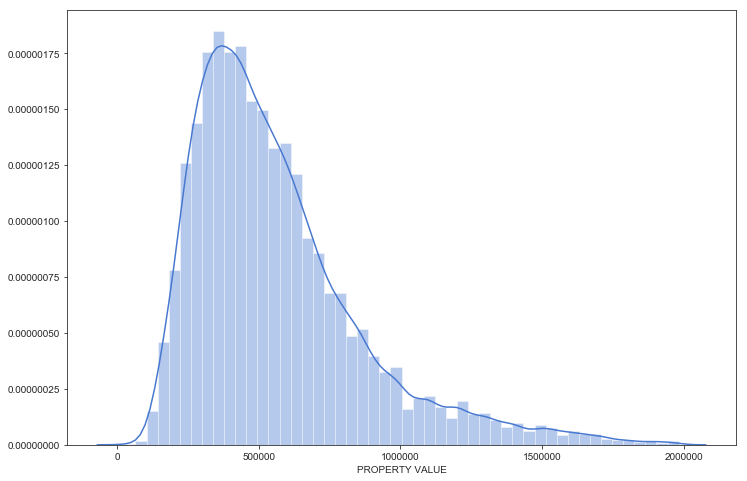

In [466]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['PROPERTY VALUE']);

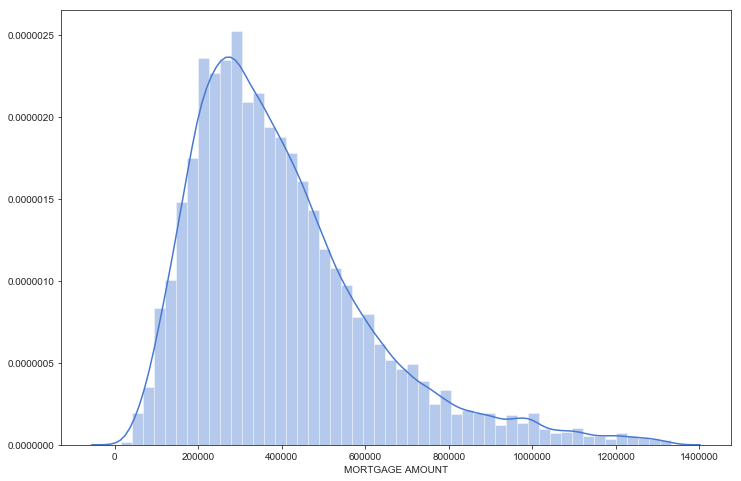

In [467]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['MORTGAGE AMOUNT']);

## EDA

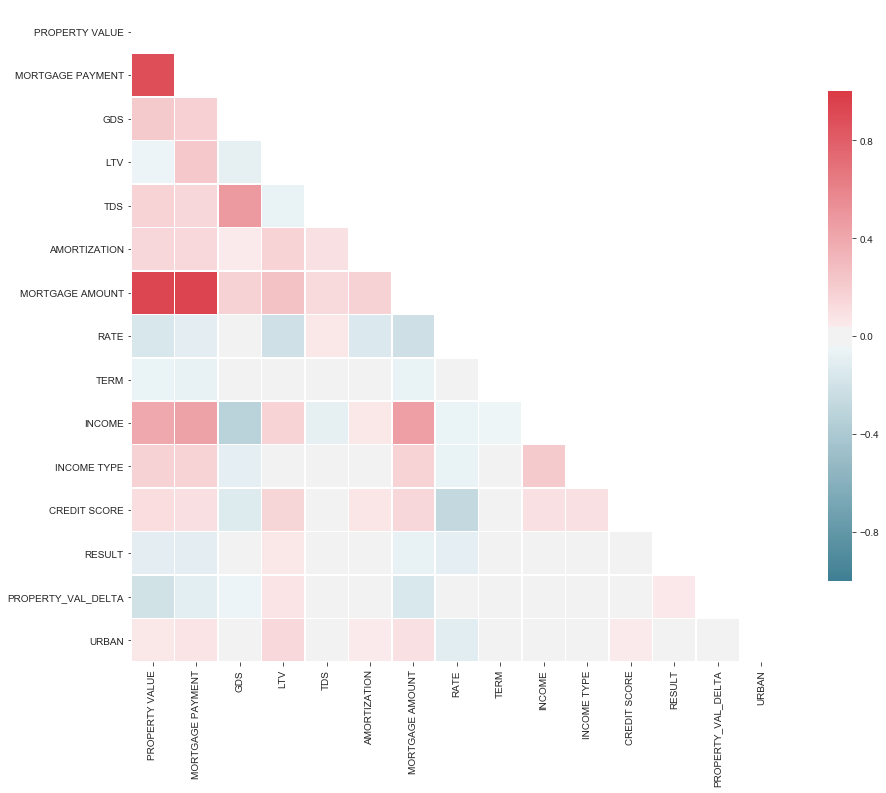

In [468]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [469]:
df.describe()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,RESULT,PROPERTY_VAL_DELTA,URBAN
count,4.429400e+04,44294.000000,44294.000000,44294.000000,44294.000000,44294.000000,4.429400e+04,44294.000000,44294.000000,4.429400e+04,44294.000000,44294.000000,44294.000000,4.429400e+04,44294.000000
mean,5.643722e+05,2240.601142,27.228614,70.874245,37.415014,355.280625,3.982254e+05,4.637140,15.338240,1.193169e+05,5.272159,661.902176,0.791868,-2.257007e+04,0.952883
std,3.031226e+05,1192.634212,12.655806,11.359826,9.549574,18.017131,2.168609e+05,0.616889,7.477367,9.665236e+04,3.278693,132.863068,0.405976,1.126585e+05,0.211891
min,2.612277e+04,141.000000,0.000000,6.667000,-10.700000,60.000000,1.500000e+04,2.750000,6.000000,2.000000e+03,-1.000000,0.000000,0.000000,-1.550007e+06,0.000000
25%,3.500000e+05,1396.000000,19.660000,65.000000,32.720000,360.000000,2.440000e+05,4.250000,12.000000,6.800000e+04,2.000000,622.000000,1.000000,-1.633333e+04,1.000000
50%,4.950000e+05,2007.000000,29.030000,75.000000,38.170000,360.000000,3.520000e+05,4.500000,12.000000,9.600000e+04,6.000000,676.000000,1.000000,0.000000e+00,1.000000
75%,6.964821e+05,2798.750000,35.670000,80.000000,41.990000,360.000000,5.000000e+05,5.000000,12.000000,1.400000e+05,8.000000,735.000000,1.000000,7.346948e+00,1.000000
max,1.981880e+06,11464.000000,99.410000,95.000000,99.960000,480.000000,1.331250e+06,8.500000,60.000000,2.400000e+06,20.000000,899.000000,1.000000,8.775000e+06,1.000000


In [470]:
df.corr()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,RESULT,PROPERTY_VAL_DELTA,URBAN
PROPERTY VALUE,1.000000,0.886646,0.210986,-0.051378,0.167778,0.145543,0.933075,-0.162853,-0.057149,0.399075,0.173354,0.109827,-0.097820,-0.201957,0.057354
MORTGAGE PAYMENT,0.886646,1.000000,0.185069,0.224630,0.143410,0.133284,0.941595,-0.095477,-0.074756,0.433161,0.167465,0.106326,-0.096495,-0.108357,0.076104
GDS,0.210986,0.185069,1.000000,-0.085853,0.483860,0.043520,0.177823,0.019567,-0.005109,-0.324349,-0.091633,-0.125247,-0.022211,-0.051477,0.003021
LTV,-0.051378,0.224630,-0.085853,1.000000,-0.065322,0.165769,0.264404,-0.210421,-0.026901,0.169892,-0.003009,0.155616,0.058435,0.076990,0.134751
TDS,0.167778,0.143410,0.483860,-0.065322,1.000000,0.094584,0.131409,0.060158,-0.028780,-0.080829,0.022119,0.022505,-0.035899,-0.038693,-0.006995
AMORTIZATION,0.145543,0.133284,0.043520,0.165769,0.094584,1.000000,0.177738,-0.144846,-0.034364,0.059628,0.027362,0.069751,0.013865,-0.021340,0.044653
MORTGAGE AMOUNT,0.933075,0.941595,0.177823,0.264404,0.131409,0.177738,1.000000,-0.214132,-0.065279,0.447169,0.170180,0.144667,-0.071905,-0.153723,0.089196
RATE,-0.162853,-0.095477,0.019567,-0.210421,0.060158,-0.144846,-0.214132,1.000000,0.003819,-0.054695,-0.064878,-0.278977,-0.087597,0.004131,-0.115729
TERM,-0.057149,-0.074756,-0.005109,-0.026901,-0.028780,-0.034364,-0.065279,0.003819,1.000000,-0.040737,0.015697,-0.008435,0.017769,-0.015800,-0.020336
INCOME,0.399075,0.433161,-0.324349,0.169892,-0.080829,0.059628,0.447169,-0.054695,-0.040737,1.000000,0.217533,0.096140,-0.010282,-0.029766,0.025470


In [471]:
#sns.pairplot(df);

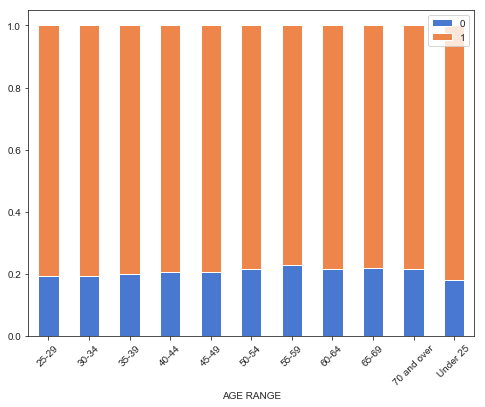

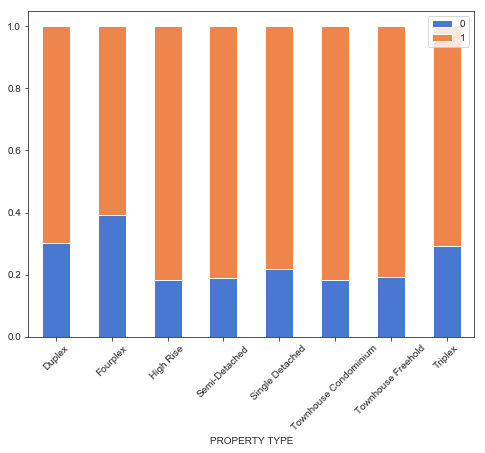

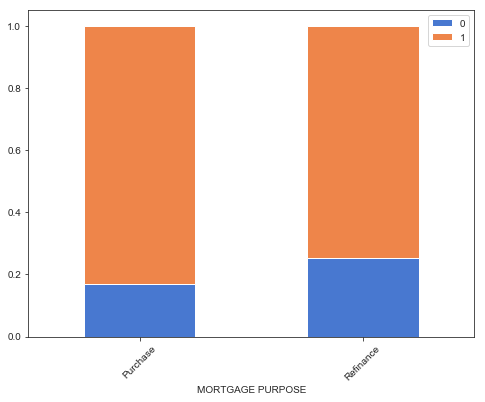

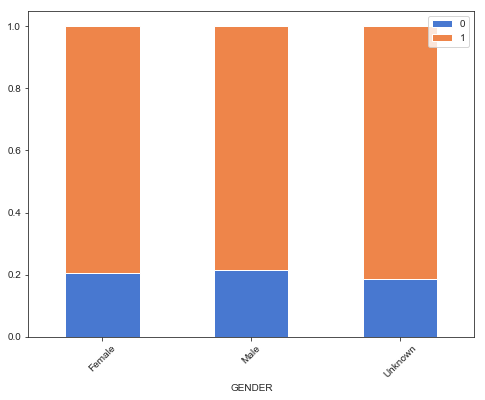

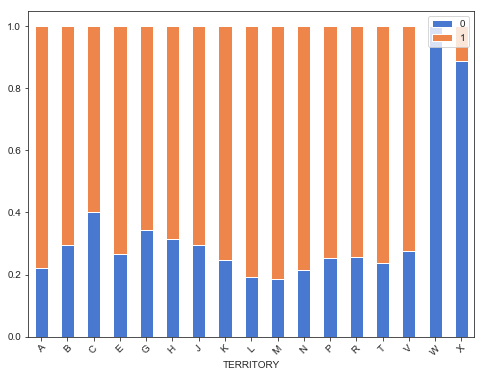

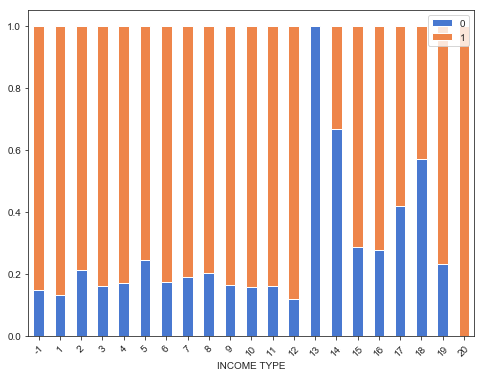

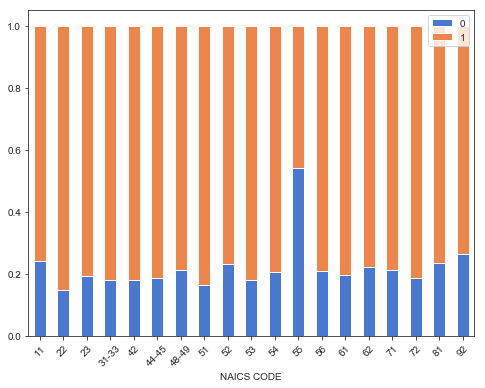

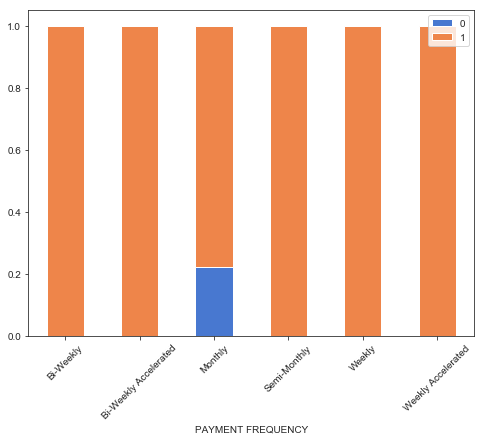

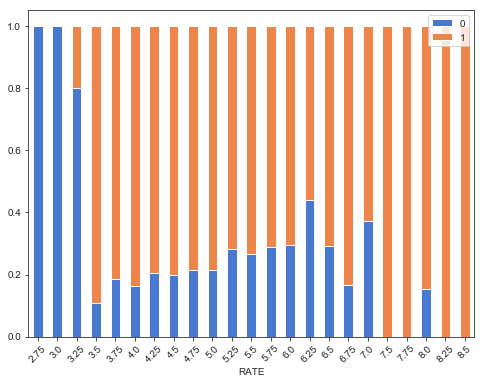

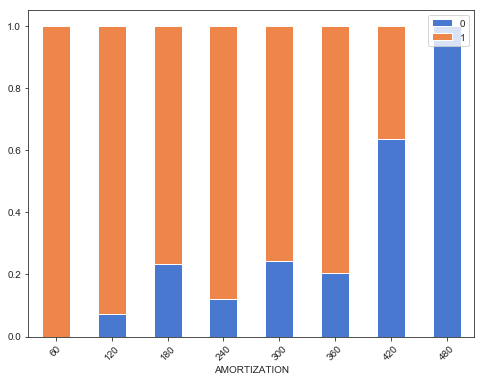

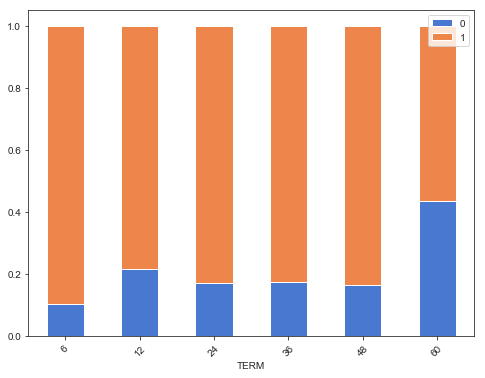

In [472]:
def stacked_bar_plot(col_1, col_2):
    
    x = df.groupby(col_1)[col_2].value_counts(normalize=True).unstack()
    x.plot(kind='bar', stacked='True', figsize=(8,6))
    plt.legend(loc=1)
    plt.xticks(rotation=45)
    plt.show();

    
stack_list = ['AGE RANGE', 'PROPERTY TYPE', 'MORTGAGE PURPOSE', 'GENDER', 'TERRITORY', \
                'INCOME TYPE', 'NAICS CODE', 'PAYMENT FREQUENCY', 'RATE', 'AMORTIZATION', 'TERM']

for feature in stack_list:
    
    stacked_bar_plot(feature, 'RESULT')


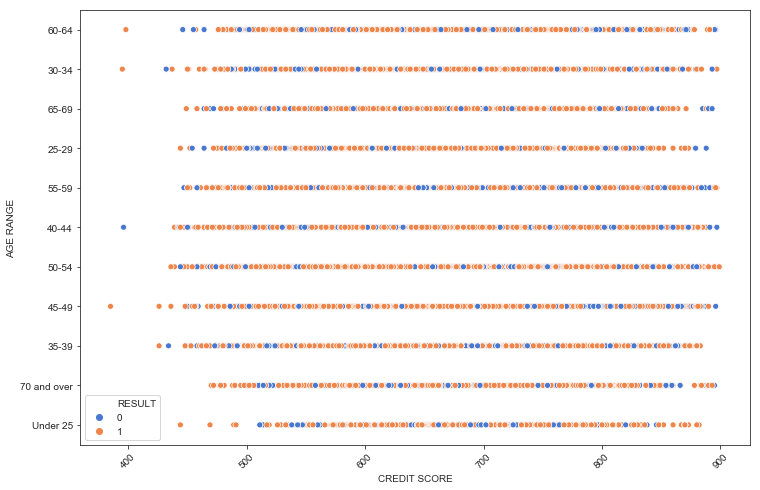

In [473]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data)
    plt.xticks(rotation=45)
    plt.show();

scatter_plot('CREDIT SCORE', 'AGE RANGE', 'RESULT', df[df['CREDIT SCORE'] > 0])

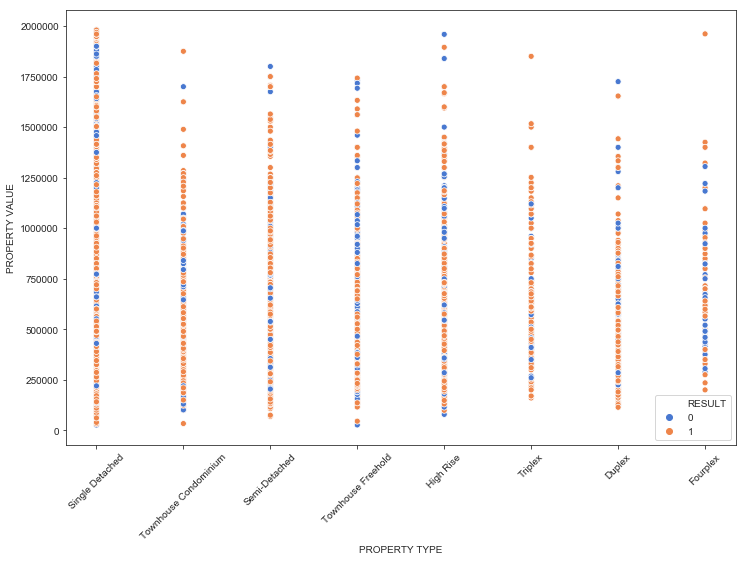

In [474]:
scatter_plot('PROPERTY TYPE', 'PROPERTY VALUE', 'RESULT', df)


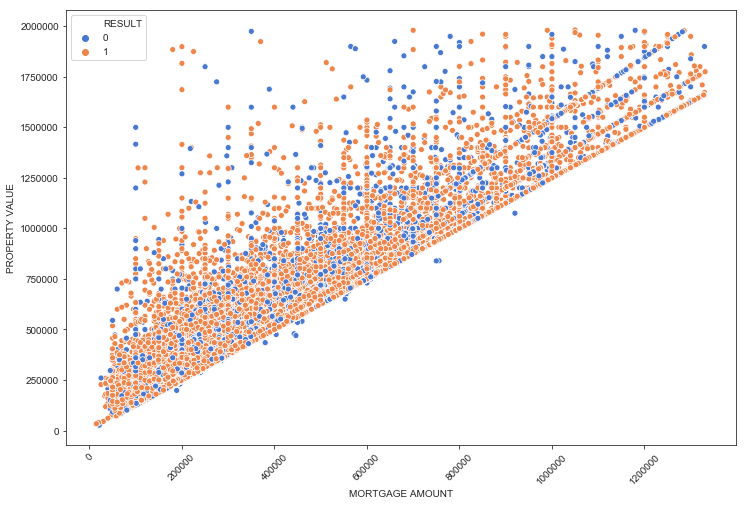

In [475]:
scatter_plot('MORTGAGE AMOUNT', 'PROPERTY VALUE', 'RESULT', df)

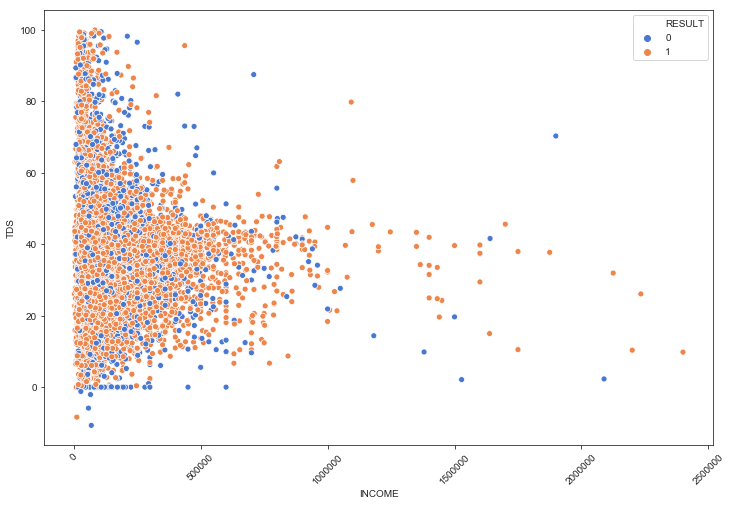

In [476]:
scatter_plot('INCOME', 'TDS', 'RESULT', df)

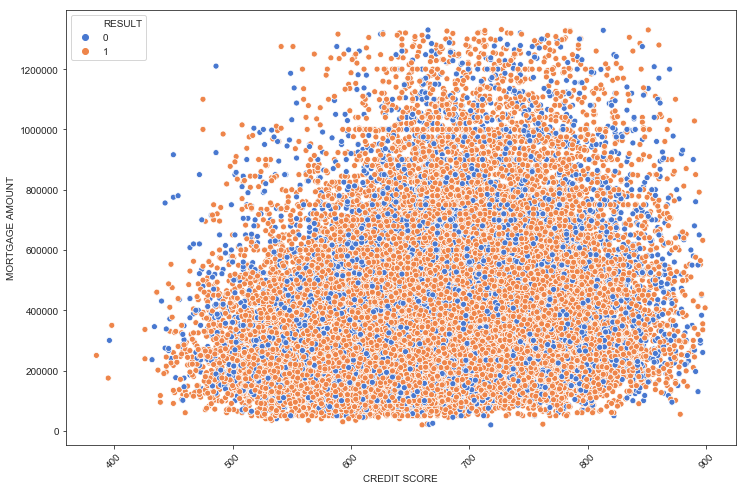

In [477]:
scatter_plot('CREDIT SCORE', 'MORTGAGE AMOUNT', 'RESULT', df[df['CREDIT SCORE'] > 0])

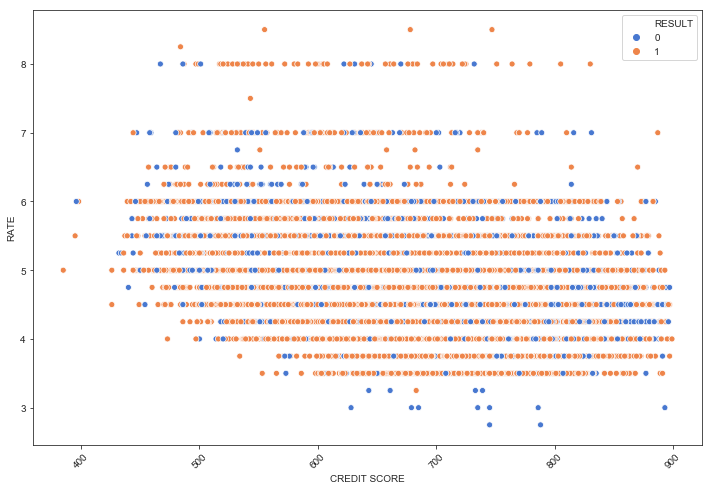

In [478]:
scatter_plot('CREDIT SCORE', 'RATE', 'RESULT', df[df['CREDIT SCORE'] > 0])

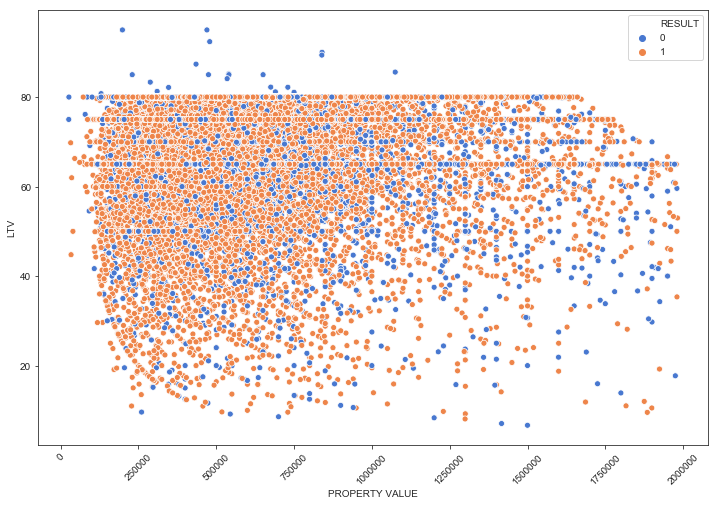

In [479]:
scatter_plot('PROPERTY VALUE', 'LTV', 'RESULT', df)

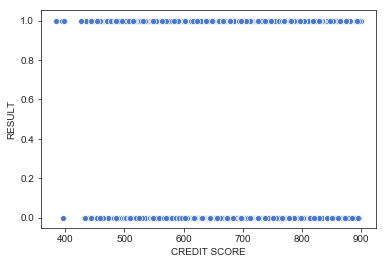

In [480]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['CREDIT SCORE'] > 0]['CREDIT SCORE']
y1 = df[df['CREDIT SCORE'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

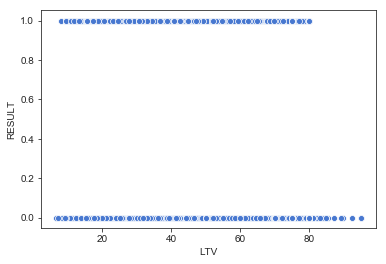

In [481]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['LTV'] > 0]['LTV']
y1 = df[df['LTV'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

In [482]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'TERRITORY', 'URBAN'],
      dtype='object')

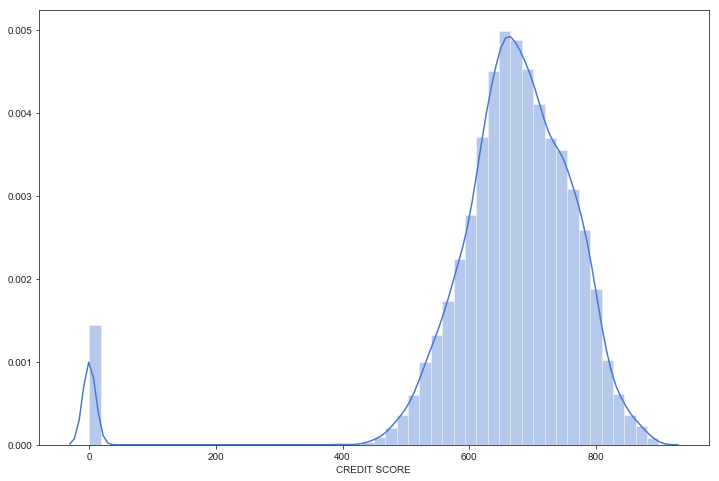

In [483]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

## ENCODING & FEATURE ENGINEERING

In [484]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'TERRITORY', 'URBAN'],
      dtype='object')

In [485]:
# Before Removing Low Value Counts
len(df)

44294

In [486]:
columns_to_check = ['TERRITORY', 'INCOME TYPE', 'RATE', 'AMORTIZATION']
thresh = 5

def remove_low_value_counts(df):
    
    for c in columns_to_check:
        
        df = df[df.groupby(c)[c].transform('size') > thresh]
        
    return df

df = remove_low_value_counts(df)

In [487]:
# After Removing Low Value Counts
len(df)

44271

In [488]:
drop_first = False

def encode(df):
    
    le = LabelEncoder()
    
    # Encode Age Range
    df['AGE RANGE'] = le.fit_transform(df['AGE RANGE'])
    df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
    df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    #df.drop(['AGE RANGE'], axis=1, inplace=True)
    
    #Encode Mortgage Purpose
    df['MORTGAGE PURPOSE'] = le.fit_transform(df['MORTGAGE PURPOSE'])
    
    #Encode Payment Frequency based on Monthly or Not
    df['PAYMENT FREQUENCY'] = np.where(df['PAYMENT FREQUENCY'] == 'Monthly', 1, 0)
    
    #Encode Gender
    df['GENDER'] = le.fit_transform(df['GENDER'])
    #df.drop(['GENDER'], axis=1, inplace=True)
    
    #Encode Term
    df['TERM'] = le.fit_transform(df['TERM'])
    
    #Territory - Drop W & X and Add Dummy Variables
    df_temp = pd.get_dummies(df['TERRITORY'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['TERRITORY'], axis=1, inplace=True)
    
    #Encode NAICS based on whether 55 or Not
    df['NAICS CODE'] = np.where(df['NAICS CODE'] == '55', 1, 0)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['PROPERTY TYPE'], axis=1, inplace=True)
    
    #Encode Income Type
    df['INCOME TYPE'] = le.fit_transform(df['INCOME TYPE'])
    
    #Encode Amortization
    df['AMORTIZATION'] = le.fit_transform(df['AMORTIZATION'])

    #Drop Columns
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    return df

df = encode(df)

In [489]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'TERM', 'AGE RANGE', 'GENDER', 'INCOME',
       'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'URBAN', 'A', 'B', 'C', 'E', 'G', 'H', 'J', 'K',
       'L', 'M', 'N', 'P', 'R', 'T', 'V', 'X', 'Duplex', 'Fourplex',
       'High Rise', 'Semi-Detached', 'Single Detached',
       'Townhouse Condominium', 'Townhouse Freehold', 'Triplex'],
      dtype='object')

In [490]:
 def add_features(df):

    avg_credit = np.mean(df['CREDIT SCORE'])
    avg_prop_val = np.mean(df['PROPERTY VALUE'])
    avg_tds = np.mean(df['TDS'])
    
    df['AVG_CREDIT'] = np.where(df['CREDIT SCORE'] > avg_credit, 1, 0)
    df['AVG_PROP_VAL'] = np.where(df['PROPERTY VALUE'] > avg_prop_val, 1, 0)
    df['AVG_TDS'] = np.where(df['TDS'] > avg_tds, 1, 0)
    
    # Binary Variable if Credit Score = Zero / Make Zero Credit Scores Equal to Mean After Encoding
    df['ZERO SCORE'] = np.where(df['CREDIT SCORE'] == 0, 0, 1)
    
    df['GDS_ZERO'] = np.where(df['GDS'] == 0, 0, 1)
    df['TDS_ZERO'] = np.where(df['TDS'] == 0, 0, 1)
    df['LOW RATE'] = np.where(df['RATE'] < 3.75, 1, 0)
    df['HIGH LTV'] = np.where(df['LTV'] > 75, 1, 0)
    
    df['INCOME_RATIO'] = df['MORTGAGE PAYMENT'] / (df['INCOME'] / 12)
    
    df['HIGH LTV'] = np.where(df['LTV'] > 75, 1, 0)
    df['LTV_80'] = np.where((df['LTV'] > 75) & (df['LTV'] < 80.1), 1, 0)
    df['LTV_75'] = np.where((df['LTV'] > 70) & (df['LTV'] < 75.1), 1, 0)
    df['LTV_70'] = np.where((df['LTV'] > 65) & (df['LTV'] < 70.1), 1, 0)
    df['LTV_65'] = np.where((df['LTV'] > 60) & (df['LTV'] < 65.1), 1, 0)
    df['LOW LTV'] = np.where(df['LTV'] < 60, 0, 1)
                             
    return df

df = add_features(df)

In [491]:
def add_natural_logs(df):
    
    cols_to_log = ['MORTGAGE AMOUNT', 'PROPERTY VALUE', 'INCOME']
    
    for col in cols_to_log:
        
        df[col] = np.log(df[col])
        
    return df

df = add_natural_logs(df)

In [492]:
apply_interactions = False

def add_interactions(df):
    
    if apply_interactions:
        
        #Interactions with 'Rate'
        df['RATE_X_CREDIT_SCORE'] = df['RATE'] * df['CREDIT SCORE']
        df['RATE_X_LTV'] = df['RATE'] * df['LTV']
        df['RATE_X_URBAN'] = df['RATE'] * df['URBAN']
        df['RATE_X_PROPERTY_VAL'] = df['RATE'] * df['PROPERTY VALUE']
        df['RATE_X_AMORTIZATION'] = df['RATE'] * df['AMORTIZATION']

         # Interaction between Urban / Rural & Property Value
        df['URBAN_X_PROPERTY_VAL'] = df['URBAN'] * df['PROPERTY VALUE']

        # LTV & Credit Score Interactions
        df['LTV_X_CREDIT'] = df['LTV'] * df['CREDIT SCORE']
        df['LTV_X_PURPOSE'] = df['LTV'] * df['MORTGAGE PURPOSE']
        df['RATE_X_PROPERTY_VAL'] = df['RATE'] * df['PROPERTY VALUE']
        df['CREDIT_X_INCOME'] = df['CREDIT SCORE'] * df['INCOME']
        df['PURPOSE_X_CREDIT'] = df['MORTGAGE PURPOSE'] * df['CREDIT SCORE']
        df['TDS_X_CREDIT'] = df['TDS'] * df['CREDIT SCORE']
        df['TDS_X_INCOME'] = df['TDS'] * df['INCOME']

        #Property Value Delta Interactions
        df['RATE_X_PROPERTY_VAL_DELTA'] = df['RATE'] * df['PROPERTY_VAL_DELTA']
        df['VAL_DELTA_X_URBAN'] = df['PROPERTY_VAL_DELTA'] * df['URBAN']
        df['VAL_DELTA_X_CREDIT'] = df['PROPERTY_VAL_DELTA'] * df['CREDIT SCORE']
        df['VAL_DELTA_X_LTV'] = df['PROPERTY_VAL_DELTA'] * df['LTV']
        df['VAL_DELTA_X_PURPOSE'] = df['PROPERTY_VAL_DELTA'] * df['MORTGAGE PURPOSE']

        df['PURPOSE_X_PROPERTY_VAL'] = df['MORTGAGE PURPOSE'] * df['PROPERTY VALUE']

        return df
    
    else:
        
        return df

df = add_interactions(df)

In [493]:
apply_poly = False

def add_polynomials(df):
    
    if apply_poly:
        
        cols_to_poly = ['GDS', 'TDS', 'LTV', 'PROPERTY VALUE', 'PROPERTY_VAL_DELTA', 'INCOME_RATIO', 'CREDIT SCORE', 'AMORTIZATION']

        for col in cols_to_poly:

            df[col+'_2'] = df[col] ** 2
            df[col+'_3'] = df[col] ** 3

        return df
    
    else:
        
        return df

df = add_polynomials(df)

In [494]:
len(df.columns)

58

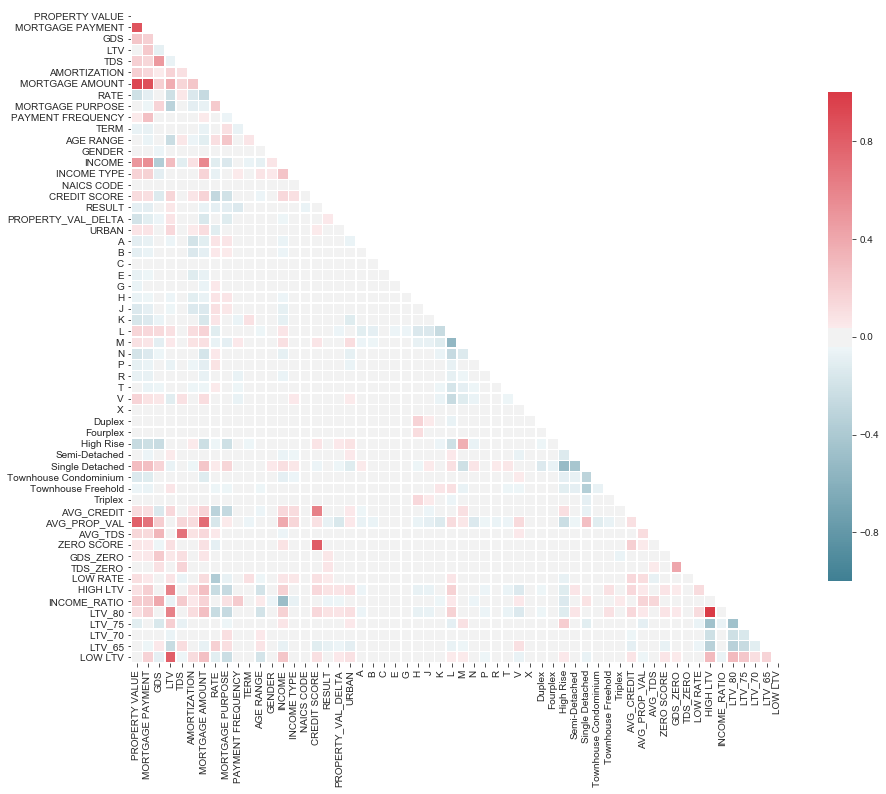

In [495]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [496]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PolynomialFeatures

## BASELINE DUMMY CLASSIFIER

In [497]:
def dummy_classifier(df):
    
    y = df['RESULT']
    X = df.drop(['RESULT'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit( X,y )
    
    print('Dummy Accuracy score: ', accuracy_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Precision score: ', precision_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Recall score: ', recall_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy AUC score: ', roc_auc_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy F1 score: ', f1_score(y_test, dummy_classifier.predict(X_test)))
        
dummy_classifier(df)

Dummy Accuracy score:  0.7981568485724612
Dummy Precision score:  0.7981568485724612
Dummy Recall score:  1.0
Dummy AUC score:  0.5
Dummy F1 score:  0.8877499748768968


## Test / Train / Split  & Scale

In [498]:
def prepare_data(df, test_size):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=17, test_size=test_size)
    
    #Scale Data
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train = pd.DataFrame(data = X_scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = X_scaler.transform(X_test), columns=features.columns)

    return X_train, X_test, y_train, y_test, y, features, X_scaler

X_train, X_test, y_train, y_test, y, features, X_scaler = prepare_data(df, 0.2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## BASELINE LOGISTIC REGRESSION

## No Adjustment for Imbalance

In [499]:
# Build Logistic Regression Function for training LogReg model
def logreg_model(X_train, y_train):

    lr = LogisticRegression(solver='liblinear')
    logreg_clf = lr.fit(X_train, y_train)

    return logreg_clf

## Build Scoring Function

In [500]:
# Scorer Function that takes in Classifier as an argument with test data
def score_model(clf, X_train, X_test, y_train, y_test):
    
    print('Model Scores for: ', '\n\n','---->', clf, '\n')
    print('Train Accuracy score: ', accuracy_score(y_train, clf.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, clf.predict(X_test)),'\n')
    print('Train F1 score: ', f1_score(y_train, clf.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, clf.predict(X_test)), '\n')
    print("Testing Precision Score: ", precision_score(y_test, clf.predict(X_test)))
    print("Testing Recall Score: ", recall_score(y_test, clf.predict(X_test)))
    print('Test AUC score: ', roc_auc_score(y_test, clf.predict(X_test)))
    
    return clf

logreg_clf = score_model(logreg_model(X_train, y_train), X_train, X_test, y_train, y_test)

Model Scores for:  

 ----> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.7947255477750169
Test Accuracy score:  0.7933370976849238 

Train F1 score:  0.884231981910252
Test F1 score:  0.8836322014498283 

Testing Precision Score:  0.7971546581000459
Testing Recall Score:  0.9911554921540656
Test AUC score:  0.5164449547491196


In [501]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (logreg_clf.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (logreg_clf.predict(X_test) == 0).sum())

Target Funded:  7010
Target Not Funded:  1845
Modeled Funded:  8716
Modeled Not Funded:  139


## Build Confusion Matrix Function

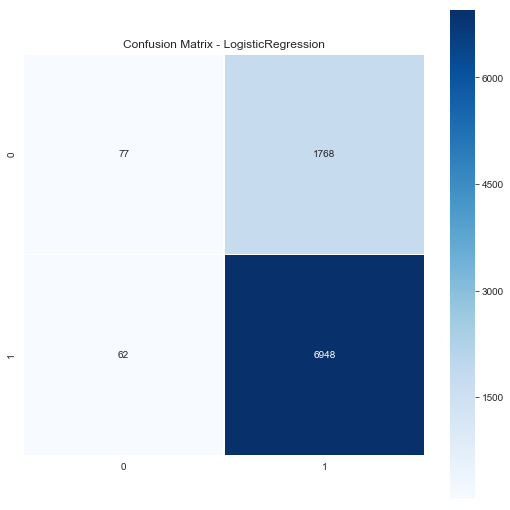

In [502]:
# Confusion Matrix Function that takes in y_test and prediction from scoring function output
def confusion_func(clf, X_test, y_test):
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (9, 9))
    plt.title(f'Confusion Matrix - {clf.__class__.__name__}')
    
    cm_lr = confusion_matrix(y_test, clf.predict(X_test))
    
    return sns.heatmap(cm_lr, annot = True, fmt = 'g', linewidths = .5, square = True, cmap = "Blues")
    
confusion_func(logreg_clf, X_test, y_test);


## Build ROC Curve Function

AUC:  0.6786053218592101


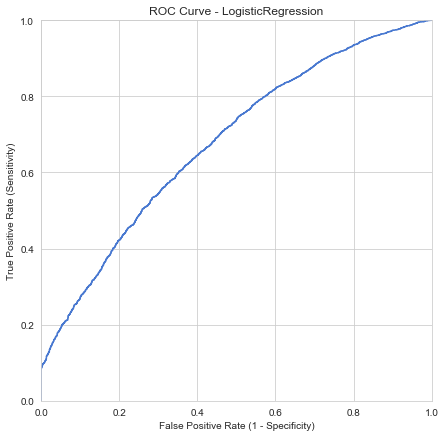

In [503]:
# ROC Function that takes in y_test and prediction from scoring function output
def ROC_func(clf, X_test, y_test):
    
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC Curve - {clf.__class__.__name__}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

    print('AUC: ', roc_auc_score(y_test, y_pred_prob));

ROC_func(logreg_clf, X_test, y_test)

In [588]:
model_params = list(zip(df.columns, logreg_clf.coef_[0]))

model_params.sort(key = lambda x: abs(x[1]), reverse=True)
model_params;

## RandomOverSample

In [505]:
def oversample_random(X_train, y_train):
    
    ros = RandomOverSampler(random_state=1)
    X_res, y_res = ros.fit_sample(X_train, y_train)
    
    X_res = pd.DataFrame(X_res, columns=X_train.columns)
    
    print(f'Before ROS: {Counter(y_train)}')
    print(f'After ROS: {Counter(y_res)}')
    
    return X_res, y_res

In [506]:
# Oversample Data - ROS
X_train_ros, y_train_ros = oversample_random(X_train, y_train)

Before ROS: Counter({1: 28054, 0: 7362})
After ROS: Counter({1: 28054, 0: 28054})


In [507]:
# def oversample_ADASYN(X_train, y_train):
    
#     adasyn = ADASYN(random_state=1)
#     X_ada, y_ada = adasyn.fit_sample(X_train, y_train)
    
#     X_ada = pd.DataFrame(X_ada, columns=X_train.columns)
    
#     print(f'Before Ada: {Counter(y_train)}')
#     print(f'After Ada: {Counter(y_ada)}')
    
#     return X_ada, y_ada

In [508]:
# Oversample Data - ADASYN
# X_train_ada, y_train_ada = oversample_ADASYN(X_train, y_train)

Before Ada: Counter({1: 28054, 0: 7362})
After Ada: Counter({0: 28153, 1: 28054})


# PCA

In [509]:
from sklearn.decomposition import PCA

In [512]:
pca = PCA(n_components=45)
X_train_pca = pca.fit_transform(X_train_ada)
X_test_pca = pca.transform(X_test)

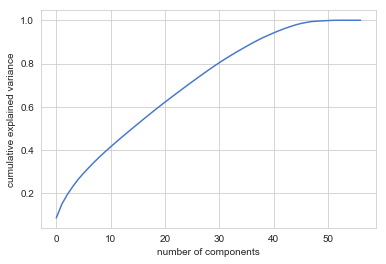

In [513]:
pca_plot = PCA().fit(X_train_ada)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Logistic Regression (Oversample)

In [514]:
# Train Model - PCA
logreg_ros_trainer_pca = logreg_model(X_train_pca, y_train_ada)

In [515]:
# Score model - PCA
logreg_clf_pca = score_model(logreg_ros_trainer_pca, X_train_pca, X_test_pca, y_train_ada, y_test)

Model Scores for:  

 ----> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.6095504118704076
Test Accuracy score:  0.6027103331451158 

Train F1 score:  0.6002113163551572
Test F1 score:  0.7040215379437995 

Testing Precision Score:  0.8580803937653815
Testing Recall Score:  0.5968616262482168
Test AUC score:  0.610896937785355


In [516]:
# Train Model - ROS
logreg_ros_trainer = logreg_model(X_train_ros, y_train_ros)

In [517]:
# Score model - ROS
logreg_ros_clf = score_model(logreg_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.6378413060526128
Test Accuracy score:  0.6281197063805759 

Train F1 score:  0.6330275229357798
Test F1 score:  0.7284123711340207 

Testing Precision Score:  0.8633431085043989
Testing Recall Score:  0.6299572039942939
Test AUC score:  0.6255477076882038


In [518]:
# Train Model - Ada
#logreg_ada_trainer = logreg_model(X_train_ada, y_train_ada)

In [519]:
# Score model - Ada
#logreg_clf_ada = score_model(logreg_ada_trainer, X_train_ada, X_test, y_train_ada, y_test)

Model Scores for:  

 ----> LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.6289963883502054
Test Accuracy score:  0.6049689440993788 

Train F1 score:  0.6149243809207245
Test F1 score:  0.7040609137055837 

Testing Precision Score:  0.8650727650727651
Testing Recall Score:  0.5935805991440799
Test AUC score:  0.6209095407644519


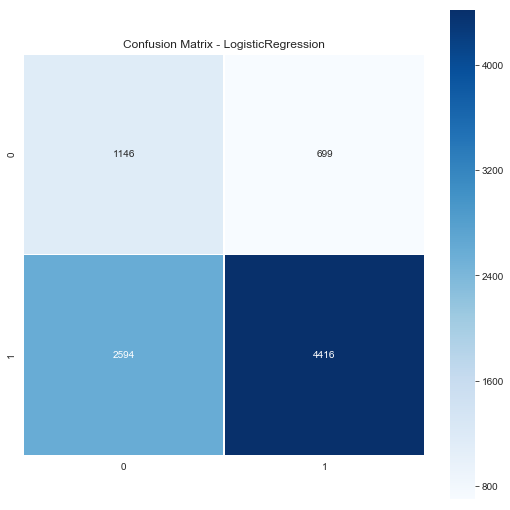

In [520]:
confusion_func(logreg_ros_clf, X_test, y_test);

AUC:  0.6796119364902636


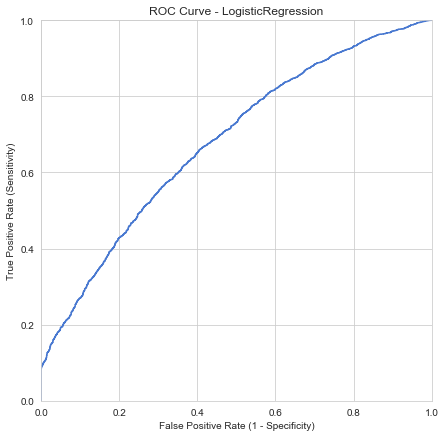

In [521]:
ROC_func(logreg_ros_clf, X_test, y_test)

# Decision Tree

In [522]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_model(X_train, y_train):
    
    criterion = 'entropy'
    max_depth = 30
    min_samples_leaf = 10
    min_impurity_decrease = 0.0005
    
    dt_clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                                    min_impurity_decrease=min_impurity_decrease)
    decision_tree_clf = dt_clf.fit(X_train, y_train)
    
    return decision_tree_clf

In [524]:
# Train Model - ROS
decision_tree_ros_trainer = decision_tree_model(X_train_ros, y_train_ros)

In [532]:
# Score model - ROS
decision_tree_clf_ros = score_model(decision_tree_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Train Accuracy score:  0.648214158408783
Test Accuracy score:  0.6767927724449464 

Train F1 score:  0.6710442985233825
Test F1 score:  0.7779329608938548 

Testing Precision Score:  0.8528411024157877
Testing Recall Score:  0.7151212553495007
Test AUC score:  0.6231432835013087


In [523]:
# Train Model - PCA
#decision_tree_pca_trainer = decision_tree_model(X_train_pca, y_train_ada)

In [525]:
# Score model - PCA
#decision_tree_clf_ros = score_model(decision_tree_pca_trainer, X_train_pca, X_test_pca, y_train_ada, y_test)

Model Scores for:  

 ----> DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Train Accuracy score:  0.6210614336292632
Test Accuracy score:  0.5370976849237719 

Train F1 score:  0.5791293694548185
Test F1 score:  0.6359356958877344 

Testing Precision Score:  0.8425511885149447
Testing Recall Score:  0.5106990014265336
Test AUC score:  0.5740486877051367


In [533]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (decision_tree_clf_ros.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (decision_tree_clf_ros.predict(X_test) == 0).sum())

Target Funded:  7010
Target Not Funded:  1845
Modeled Funded:  5878
Modeled Not Funded:  2977


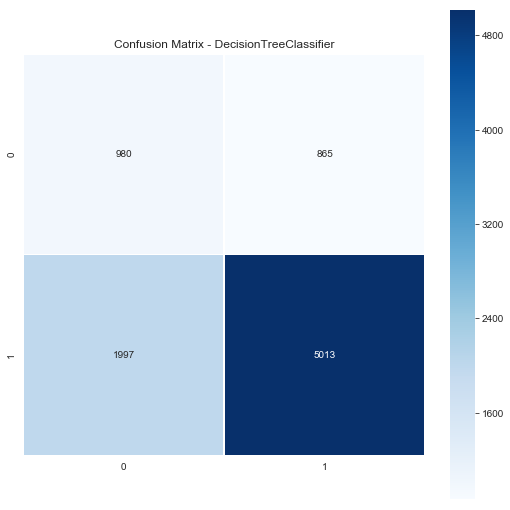

In [534]:
confusion_func(decision_tree_clf_ros, X_test, y_test);

AUC:  0.6805511290490937


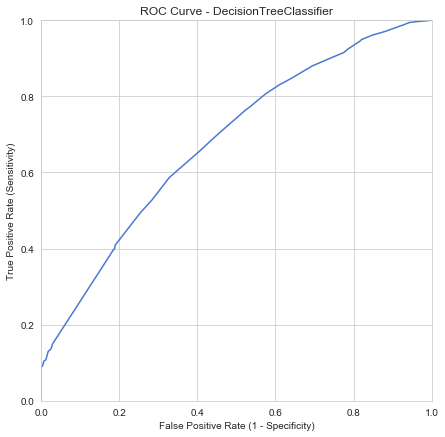

In [535]:
ROC_func(decision_tree_clf_ros, X_test, y_test)

In [536]:
# Build Function to print Feature Importance

def print_feature_importance(clf, X_train, top_n=50):
    
    title = f'Feature Importance - {clf.__class__.__name__}'
    figsize = (10,10)
    
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()

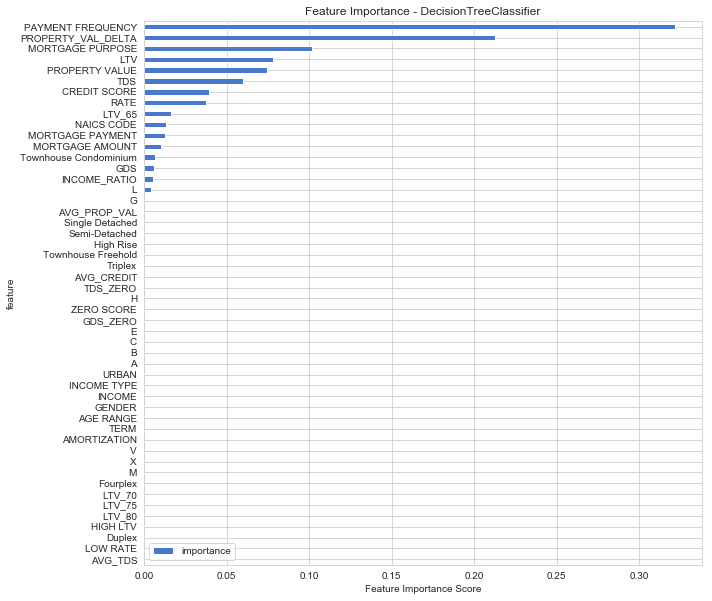

In [537]:
#Feature Importance - ROS
print_feature_importance(decision_tree_clf_ros, X_train)

## Random Forest Classifier

In [538]:
from sklearn.ensemble import RandomForestClassifier

In [539]:
def rfc_model(X_train, y_train):
    
    criterion = 'entropy'
    max_features = 0.375
    n_estimators = 400
    class_weight = 'balanced'
    min_samples_leaf = 15
    
    rfc = RandomForestClassifier(criterion=criterion, n_estimators=n_estimators, class_weight=class_weight, \
                                 min_samples_leaf=min_samples_leaf, random_state=1)
    rfc_clf = rfc.fit(X_train, y_train)
    
    return rfc_clf

In [540]:
#Train PCA Model
#rfc_PCA_trainer = rfc_model(X_train_pca, y_train_ada)

In [541]:
# Score model
#rfc_clf_PCA = score_model(rfc_PCA_trainer, X_train_pca, X_test_pca, y_train_ada, y_test)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False) 

Train Accuracy score:  0.9436013307950967
Test Accuracy score:  0.682326369282891 

Train F1 score:  0.9422312935087654
Test F1 score:  0.787906205232602 

Testing Precision Score:  0.8355989125219895
Testing Recall Score:  0.7453637660485022
Test AUC score:  0.594091097116392


In [542]:
# Train Model - ROS
rfc_ros_trainer = rfc_model(X_train_ros, y_train_ros)

In [543]:
# Score model - ROS
rfc_clf_ros = score_model(rfc_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False) 

Train Accuracy score:  0.8953090468382405
Test Accuracy score:  0.7294184076792772 

Train F1 score:  0.8933976988131104
Test F1 score:  0.823042836041359 

Testing Precision Score:  0.853292496171516
Testing Recall Score:  0.7948644793152639
Test AUC score:  0.6378116434516699


In [544]:
# Train Model - Ada
#rfc_ada_trainer = rfc_model(X_train_ada, y_train_ada)

In [545]:
# Score model - Ada
#rfc_clf_ada = score_model(rfc_ada_trainer, X_train_ada, X_test, y_train_ada, y_test)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False) 

Train Accuracy score:  0.9013290159588664
Test Accuracy score:  0.7582156973461321 

Train F1 score:  0.906101855614249
Test F1 score:  0.8544626469988444 

Testing Precision Score:  0.8161277756135566
Testing Recall Score:  0.8965763195435092
Test AUC score:  0.5645483223733807


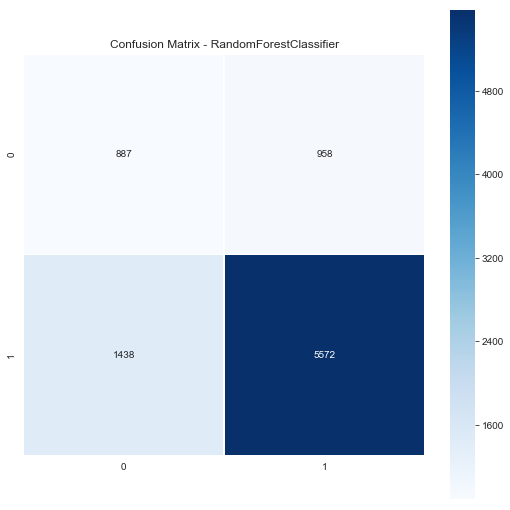

In [550]:
confusion_func(rfc_clf_ros, X_test, y_test);

AUC:  0.713859179105343


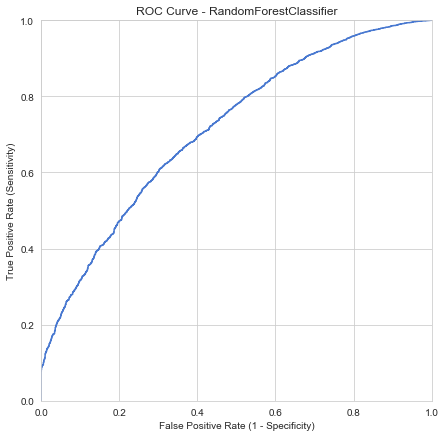

In [555]:
ROC_func(rfc_clf_ros, X_test, y_test)

In [554]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (rfc_clf_ros.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (rfc_clf_ros.predict(X_test) == 0).sum())

Target Funded:  7010
Target Not Funded:  1845
Modeled Funded:  6530
Modeled Not Funded:  2325


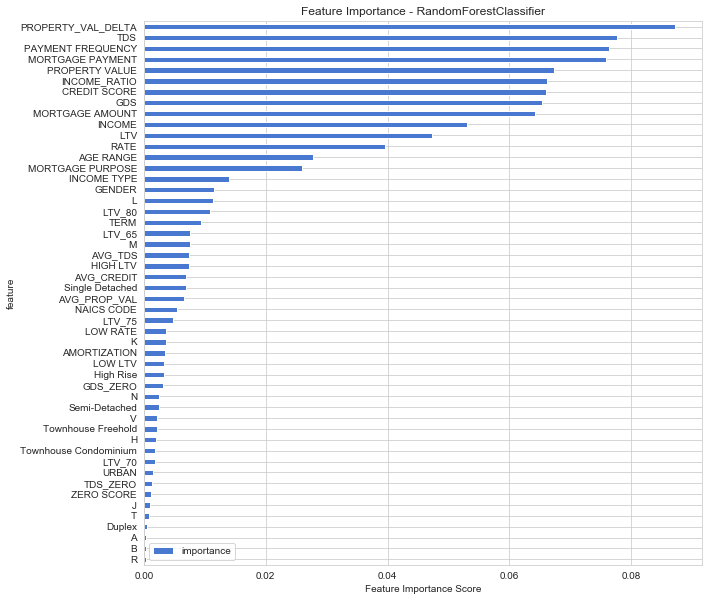

In [553]:
#Feature Importance - RFC
print_feature_importance(rfc_clf_ros, X_train)

## Grid Search - RFC

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
rfc_parameters = {
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.375, 0.50, 0.625),
                'n_estimators': [400, 450, 500],
                'min_samples_leaf': [15, 25, 35]
                }

def run_grid_search(clf, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'f1'
    
    grid = GridSearchCV(clf, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train_ros, y_train_ros)
    
    best_grid_clf = grid.best_estimator_
    
    print('Grid Search: ', clf.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_clf

In [ ]:
best_rfc_grid_clf = run_grid_search(RandomForestClassifier(class_weight = 'balanced'), rfc_parameters, X_train_ros, y_train_ros)

## Randomized Search

In [ ]:
dt_param_distributions = {
                  'criterion': ['entropy', 'gini'],
                  'max_depth': range(5,50, 2), 
                  'min_samples_leaf': range(1,25, 2),
                  'min_impurity_decrease': [0.0005, 0.00075],
                  'min_samples_split': [2, 3]
                 }
    
rfc_param_distributions = {
              'criterion': ['entropy', 'gini'],
              'n_estimators': [150, 200, 250, 300, 350, 400],
              'max_features': [0.50, 0.625, 0.75],
             }

def run_randomized_search(clf, params, X_train, y_train):
    
    cv = 5
    scoring = 'f1'

    randomized_search = RandomizedSearchCV(estimator=clf, cv=cv, param_distributions=params, scoring=scoring, verbose=10)
    randomized_search = randomized_search.fit(X_train, y_train)

    best_clf = randomized_search.best_estimator_
    
    print('Randomized Search: ', clf.__class__.__name__, '\n')
    print('Randomized Search Best Score: ', randomized_search.best_score_)
    print('Ranodmized Search Best Params: ', randomized_search.best_params_)
    print('Randomized Search Best Estimator: ', randomized_search.best_estimator_)

    return best_clf

In [ ]:
best_rfc_clf = run_randomized_search(RandomForestClassifier(), rfc_param_distributions, X_train_ros, y_train_ros)

## XGBoost

In [270]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [271]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"

In [272]:
def xgb_model(X_train, y_train):
    
    objective = 'binary:logistic'
    colsample_bytree = 0.8
    learning_rate = 0.10
    max_depth = 40
    alpha = 15
    n_estimators = 250

    xgb_clf = xgb.XGBClassifier(objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, alpha=alpha, n_estimators=n_estimators)
    
    xgb_clf = xgb_clf.fit(X_train, y_train)
    
    return xgb_clf

In [273]:
# Train Model
xgb_trainer_ros = xgb_model(X_train_ada, y_train_ada)

In [274]:
# Score model
X_test = X_test[X_train_ada.columns]
xgb_clf = score_model(xgb_trainer_ros, X_train_ada, X_test, y_train_ada, y_test)

Model Scores for:  

 ----> XGBClassifier(alpha=15, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=40, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) 

Train Accuracy score:  0.999982210520698
Test Accuracy score:  0.8066629023150762 

Train F1 score:  0.9999821342432959
Test F1 score:  0.8880606773898261 

Testing Precision Score:  0.8265579357351509
Testing Recall Score:  0.9594518225487426
Test AUC score:  0.578769242731884


In [280]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (xgb_clf.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (xgb_clf.predict(X_test) == 0).sum())

Target Funded:  7078
Target Not Funded:  1777
Modeled Funded:  8216
Modeled Not Funded:  639


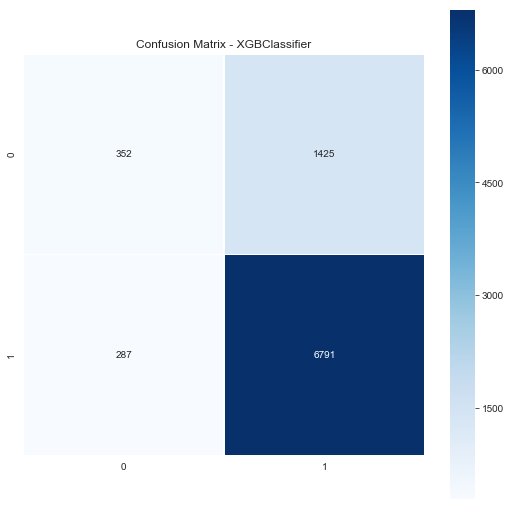

In [281]:
confusion_func(xgb_clf, X_test, y_test);

AUC:  0.7101518762791584


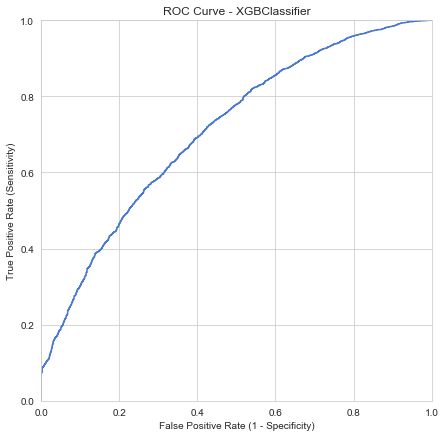

In [282]:
ROC_func(xgb_clf, X_test, y_test)

## Run on Test Set for Competition

In [568]:
file = pd.read_csv('CAX_MortgageModeling_Test.csv')
submission = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv')

test_df = pd.DataFrame(file)
submission_df = pd.DataFrame(submission)
submission_df.set_index('Unique_ID', inplace=True)

test_df = test_df.drop(['RESULT'], axis=1)

In [569]:
test_df = add_interactions(add_natural_logs(add_features(encode(clean_data(test_df)))))

In [570]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( test_df.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_df = test_df[X_train.columns]

In [571]:
test_df = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [572]:
#test_df = pca.transform(test_df)

In [573]:
# Score model - RFC
print('Modeled Funded: ', (rfc_clf_ada.predict(test_df) == 1).sum())
print('Modeled Not Funded: ', (rfc_clf_ada.predict(test_df) == 0).sum())

Modeled Funded:  13216
Modeled Not Funded:  1998


In [582]:
rfc_submission = rfc_clf_ada.predict(test_df)

In [583]:
submission_df['Result_Predicted'] = rfc_submission

In [584]:
submission_df['Result_Predicted'] = submission_df['Result_Predicted'].replace({1: 'FUNDED', 0: 'NOT FUNDED'})

In [585]:
submission_df['Result_Predicted'].value_counts()

FUNDED        13216
NOT FUNDED     1998
Name: Result_Predicted, dtype: int64

In [586]:
submission_df.to_csv('submission.csv')

In [587]:
submission_df.shape

(15214, 1)